# Interfacing with C code
Sometimes you get provide an instrument driver as a C static library, or a dynamic linked library/shared object. In these cases to access the functions we must write a python wrapper.

The easiest case is when you already have a .dll or a .so file:
- use ctypes to expose the functions.
https://docs.python.org/3/library/ctypes.html

When you have a static library, it is up to you to write a wrapper and you will need a C compiler installed:
- Use Cython to produce a wrapper.  This requires a compiler.
    - Sometimes C++ code is very annoying to wrap in Cython as you must make a complete set of function/class definitions.  For C++ code, I generally write a wrapper in C++ that produces easy to call functions from python.
- Use ctypes to produce a wrapper that is purely written in python.  This is quick to setup, and easy to use.

# Installing compiler on windows
Follow instructions here.  It is pretty straight forward now.

https://wiki.python.org/moin/WindowsCompilers

Make sure you check the cmd line build tools and the windows 10 sdk.

https://visualstudio.microsoft.com/downloads/#build-tools-for-visual-studio-2017

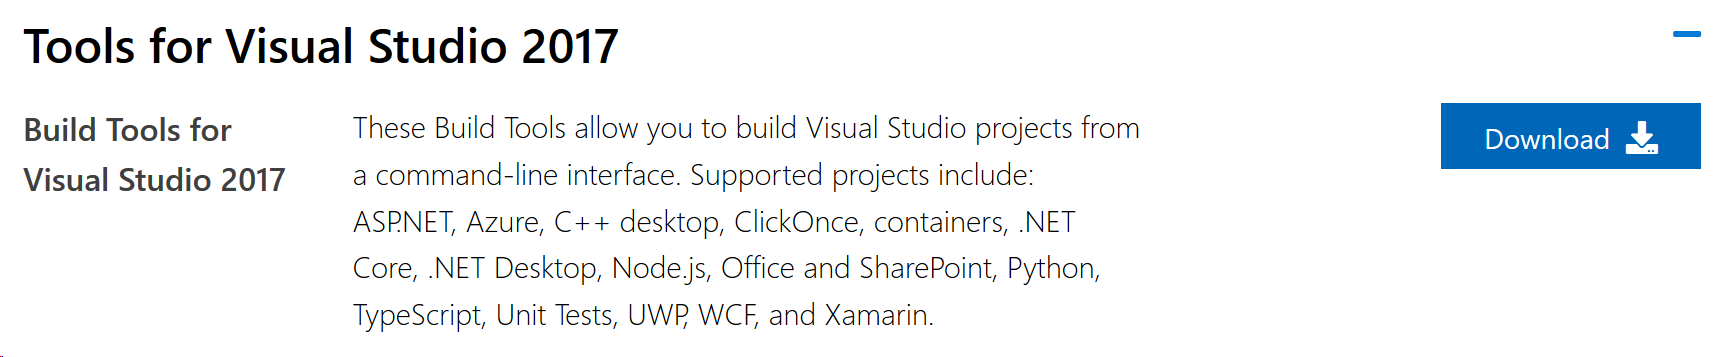

# Writing C code that you can access from python
Although python is quick to write, sometimes highly tuned C-code can really speed up a critical section of your code.
There are several ways to interface with high speed C-code:
- my favorite is to write a simple function in pure C, and then make a wrapper in python. 
- Other techniques involve writing C-code that is aware of python objects.

Here is a sample C code file that is relatively complex.  It uses the vectorization intrinsics to fine tune a function for speed.  The top line indicates the compiler option to produce a dll function in windows.

Don't worry about the complexity of the c code..  What is important are there are three functions it exports.

## These are the functions available in the iii.DLL
You will typically get the function definition and maybe some documentation
```c
// simple summation that takes 
int sum(int a, int b);

void dum(float *a);
void broadcastrealcomplexmul(__m128 *realarray,float *mode,__m128 *out,unsigned int M, unsigned int N);
```
## Here is the c code that produced the iii.DLL

```c

//"C:\Program Files (x86)\Microsoft Visual Studio\2017\BuildTools\VC\Auxiliary\Build\vcvarsx86_amd64.bat" && set OMP_NUM_THREADS=3 && cl /LD /Ox /openmp iii.c
#include <stdio.h>
//MMX
//#include <mmintrin.h>
//SSE
#include <xmmintrin.h>
//SSE2
#include <emmintrin.h>
//SSE3
#include <pmmintrin.h>
//SSE4
#include <smmintrin.h>
//AVX
#include <immintrin.h>
#include <math.h>

// Stuff 
#ifdef __cplusplus
#define EXT_C extern "C"
#else
#define EXT_C
#endif

//Proper DLL expert for linux or windows
#ifdef _WIN32
	#define EXPORT EXT_C __declspec(dllexport)
#else
	#define EXPORT EXT_C __attribute__((visibility("default")))
#endif

// Simple function to export
EXPORT int sum(int a, int b) {
    return a + b;
}

// more complicated function to export
EXPORT void dum(float *a) {
    a[0]=1;
}

// Extremely coplicated function to export that takes in float32 arrays represented as vectors
EXPORT void broadcastrealcomplexmul(__m128 *realarray,float *mode,__m128 *out,unsigned int M, unsigned int N)
{

	const int blockSize = 4;
	const int n = N; // 1 complexes at a time
	const int mr = M/ (4); // 4 reals step
	const int mc = M/ (2); //compl step
  
	//real array has shape N,M/4
	//out array has shape  N,M/2
	//mode has shape of N 
	//go the wrong way through the array??
	//load 4 reals to be multiplied by complex?
		for (int i = 0; i < n; i ++)
		{
            //i is the row we are at... do 2 complex rows at a time....

			//Extract real and imaginary components for 4 numbers
			
			__m128 yR = _mm_set1_ps(mode[2*i]);//_mm_shuffle_ps(y0, y1, _MM_SHUFFLE(0, 2, 0, 2));
			__m128 yI = _mm_set1_ps(mode[2*i+1]);//_mm_shuffle_ps(y0, y1, _MM_SHUFFLE(1, 3, 1, 3));
			
			for (int k=0; k<mr ; k++)
			{

                
                
				//load 4 numbers from real array...
				__m128 rv = realarray[k+i*mr]; // skip m for next row
				
				__m128 xR = _mm_mul_ps(rv,yR); //4 real multiplies
				__m128 xI = _mm_mul_ps(rv,yI); //4 imag multiplies
			
				__m128 lo = _mm_unpacklo_ps(xR, xI);
				__m128 hi = _mm_unpackhi_ps(xR, xI);

				out[    i*mc  + 2*k   ] =  lo;
				out[    (i)*mc  + 2*k+1 ] = hi;
			

			}
				
		}

}
```

# Using Ctypes to wrap iii.dll

Suppose we have the iii.dll. We know it has 3 functions in it that we can call.  Ctypes is used to load the dll in python, and provide the proper conversion of python types to ctypes such that the function can be called directly from python.  

Often some instruments provide a dll to interface to their equipment.  Most commonly, these types equipment are cards that fit inside a computer such as a frame grabber for a camera or a digitizer, or a dac.  

```c
// simple summation that takes 
int sum(int a, int b);

void dum(float *a);
void broadcastrealcomplexmul(__m128 *realarray,float *mode,__m128 *out,unsigned int M, unsigned int N);
```


In [4]:
##python code that wraps the iii.dll

import ctypes,_ctypes
from numpy.ctypeslib import ndpointer
import numpy as np

lib = ctypes.cdll.LoadLibrary("iii.dll") #might need to get the full path correct

#Wrap the function
#int sum(int a, int b);
iii_sum = lib.sum 
iii_sum.restype = ctypes.c_uint32
iii_sum.argtypes = [
                ctypes.c_uint32,
                ctypes.c_uint32,
                ]
#now you can call it

#wrap the dum function (it is expected to take a numpy array)
#void dum(float *a);
iii_dum = lib.dum 
iii_dum.restype = None # void for return
iii_dum.argtypes = [
                ndpointer(np.float32, flags="C_CONTIGUOUS",ndim=1)  #expect number array with float32,not float64
                ]

#wrap a more copmlicated function
mul_real_complex_complex_f = lib.broadcastrealcomplexmul
mul_real_complex_complex_f.restype = None


#void broadcastrealcomplexmul(__m128 *realarray,__m128 *mode,__m128 *out,unsigned int M, unsigned int N)
mul_real_complex_complex_f.argtypes = [ ndpointer(ctypes.c_float, flags="C_CONTIGUOUS",ndim=2),
                ndpointer(np.complex64, flags="C_CONTIGUOUS",ndim=1),
                ndpointer(np.complex64, flags="C_CONTIGUOUS",ndim=2),
                ctypes.c_uint32,
                ctypes.c_uint32,
                ]



In [5]:
#EXample of the sum
iii_sum(1,2) ## Should output 3

3

In [10]:
#example of the dum
a = np.array([23,24,0],dtype=np.float32) # remember dum is for float 32

print('input',a)
iii_dum(a)
print('output',a[:10])
print('you can see a[0] is replaced with 1')

input [ 23.  24.   0.]
output [  1.  24.   0.]
you can see a[0] is replaced with 1


In [22]:
#example of broadcast multiply
#multiplies each row of a index as i, by b[i] 
#a*b[None].T

M,N = 4,8  #
a = np.ones((N,M),dtype=np.float32) 
output = np.ones((N,M),dtype=np.complex64) 
b = np.arange(N,dtype=np.complex64)
mul_real_complex_complex_f(a,b,output,M,N)

print(a)
print(output)

[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  1.+0.j  1.+0.j  1.+0.j]
 [ 2.+0.j  2.+0.j  2.+0.j  2.+0.j]
 [ 3.+0.j  3.+0.j  3.+0.j  3.+0.j]
 [ 4.+0.j  4.+0.j  4.+0.j  4.+0.j]
 [ 5.+0.j  5.+0.j  5.+0.j  5.+0.j]
 [ 6.+0.j  6.+0.j  6.+0.j  6.+0.j]
 [ 7.+0.j  7.+0.j  7.+0.j  7.+0.j]]


In [24]:
#Speed test of numpy version, vs fast c version
M,N = 256,1024  #
a = np.ones((N,M),dtype=np.float32) 
output = np.ones((N,M),dtype=np.complex64) 
b = np.arange(N,dtype=np.complex64)


#simply numpy functions
%timeit a*b[None].T

#ultra fast vectorized version (10x faster on my machine)
%timeit mul_real_complex_complex_f(a,b,output,M,N)

1.39 ms ± 46.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
120 µs ± 4.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Useful ctypes interface to a Measurement Computing DAQ

Measurement Computing DAC are a USB powered DAQ which has digital outputs, analog ouptuts, analog inputs etc... We use them a lot to control the bias voltages on IQ modulators. They provide a dll to their instacal library.
https://www.mccdaq.com/

In [25]:
import ctypes

## on my windows I need to use the 64bit version of the dll
cbw = ctypes.windll.cbw64

def changeVoltage(BoardNum, Chan,  DataValue):
    '''Change the voltage on the MCDAC'''
    error =  cbw.cbAOut(BoardNum, Chan, 1, int(DataValue))
    if error !=0:
        raise
        
#if you want to change the voltage, do this!! 
changeVoltage(0,1,30000)

OSError: [WinError 126] The specified module could not be found